In [26]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from math import log10, sqrt
from skimage.measure import compare_ssim

In [27]:
!pip install pycryptodome
from Crypto.Cipher import AES
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


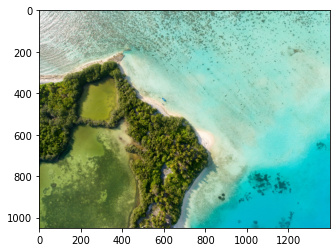

In [28]:
original_img = cv2.imread('/content/drive/My Drive/Colab Notebooks/img.jpeg')



o_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
steg_img = o_img.copy()
s_img = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB)

cv2.imwrite('/content/drive/My Drive/Colab Notebooks/s_img.jpeg',s_img)

plt.imshow(o_img)

# -1 means unknown, it will be automatically calculated
vector_img = o_img.reshape((-1, 3))

In [29]:
vector_img = np.float32(vector_img)
vector_img.shape

(1468600, 3)

In [30]:
class Stage1:
	def __init__(self,p,dim,id=-1):
		self.coordinates = []
		self.pointList = []
		self.id = id
		self.pointCentroid = 0
		for x in range(0,dim):
			self.coordinates.append(p[x]);
		self.centroid = None
		
class Stage2:
	count = 0
	def __init__(self,point):
		self.point = point
		self.count = Centroid.count
		self.pointList = []
		self.centerPos = []
		self.predictions = []
		self.centerPos.append(self.point)
		self.centroid = None
		Centroid.count += 1

	def update(self,point):
		self.point = point
		self.centerPos.append(self.point)
		
	def addPoint(self,point):
		self.pointList.append(point)
		
	def removePoint(self,point):
		self.pointList.remove(point)
		

class Kmeans:
	def __init__(self, k, pointList, kmeansThreshold, initialCentroids = None):
		self.pointList = []
		self.numPoints = len(pointList)
		self.k = k
		self.initPointList = []
		self.dim = len(pointList[0])
		self.kmeansThreshold = kmeansThreshold
		self.error = None
		self.errorList = []
		self.closestClusterDistance = {}
		i = 0
		for point in pointList:
			p = Point(point,self.dim,i)
			i += 1
			self.pointList.append(p)
			self.closestClusterDistance[p.id] = -1

		if initialCentroids != None:
			self.centroidList = self.seeds(initialCentroids)
		else:
			self.centroidList = self.selectSeeds(self.k)
		self.mainFunction()

	def selectSeeds(self,k):
		seeds = random.sample(self.pointList, k)
		centroidList = []
		for seed in seeds:
			centroidList.append(Centroid(seed))
		return centroidList

	def seeds(self,initList):
		centroidList = []
		for seed in initList:
			centroidList.append(Centroid(seed))
		return centroidList

	def getDistance(self,point1,point2):
		distance = 0
		for x in range(0,self.dim):
			distance += (point1.coordinates[x]-point2.coordinates[x])**2 
		return (distance)**(0.5)

	def getCentroidInit(self,point):
		minDist = -1
		pos = 0
		for centroid in self.centroidList:
			dist = self.getDistance(point,centroid.point)
			if minDist == -1:
				minDist = dist
				closestCentroid = pos
			elif minDist > dist:
				minDist = dist
				closestCentroid = pos
			pos += 1
		return (closestCentroid, minDist)

	def getCentroid(self,point):
		pos = 0
		dist = self.getDistance(point,self.centroidList[point.centroid].point)
		minDist = dist
		closestCentroid = point.centroid
		currCentroid =  point.centroid
		if self.closestClusterDistance[point.id] < dist:
			for centroid in self.centroidList:
				if pos != currCentroid:
					dist = self.getDistance(point,centroid.point)
					if minDist > dist:
						minDist = dist
						closestCentroid = pos
				pos += 1
		self.closestClusterDistance[point.id] = minDist
		return (closestCentroid, minDist)


	def reCalculateCentroid(self):
		pos = 0
		for centroid in self.centroidList:
			zeroArr = []
			for x in range(0,self.dim):
				zeroArr.append(0)
			mean = Point(zeroArr,self.dim)
			for point in centroid.pointList:
				for x in range(0,self.dim):
					mean.coordinates[x] += point.coordinates[x]
			for x in range(0,self.dim):
				try:
					mean.coordinates[x] = mean.coordinates[x]/len(centroid.pointList)
				except:
					mean.coordinates[x] = 0
			centroid.update(mean)
			self.centroidList[pos] = centroid
			pos += 1
	
	def assignPointsInit(self):
		for i in range(len(self.pointList)-1,-1,-1):
			temp = self.getCentroidInit(self.pointList[i])
			centroidPos = temp[0]
			centroidDist = temp[1]
			self.closestClusterDistance[self.pointList[i].id] = centroidDist
			if self.pointList[i].centroid is None:
				self.pointList[i].centroid = centroidPos
				self.centroidList[centroidPos].pointList.append(copy.deepcopy(self.pointList[i]))
			

	def assignPoints(self):
		doneMap = {}
		for i in range(len(self.centroidList)-1,-1,-1):
			for j in range(len(self.centroidList[i].pointList)-1,-1,-1):
				try:
					a = doneMap[self.centroidList[i].pointList[j].id]
				except:
					doneMap[self.centroidList[i].pointList[j].id] = 1
					temp = self.getCentroid(self.centroidList[i].pointList[j])
					centroidPos = temp[0]
					centroidDist = temp[1]
					if self.centroidList[i].pointList[j].centroid != centroidPos:
						self.centroidList[i].pointList[j].centroid = centroidPos
						self.centroidList[centroidPos].pointList.append(copy.deepcopy(self.centroidList[i].pointList[j]))
						del self.centroidList[i].pointList[j]


	def calculateError(self,config):
		error = 0
		for centroid in self.centroidList:
			for point in centroid.pointList:
				error += self.getDistance(point,centroid.point)**2
		return error



	def errorCount(self):
		self.t = threading.Timer(0.5, self.errorCount)
		self.t.start()
		startTime = time.time()
		timeStamp = 0

	def mainFunction(self):
		self.iteration = 1
		self.ti = 0.0
		self.errorCount()
		error1 = 2*self.kmeansThreshold+1
		error2 = 0
		iterationNo = 0
		self.currentTime = time.time()
		self.startTime = time.time()
		self.assignPointsInit()
		while(abs(error1-error2)) > self.kmeansThreshold:
			iterationNo += 1
			self.iteration = iterationNo
			error1 = self.calculateError(self.centroidList)
			self.error = error1		
			self.reCalculateCentroid()
			self.assignPoints()
			error2 = self.calculateError(self.centroidList)
			self.error = error2

		self.t.cancel()


def makeRandomPoint(n, lower, upper):
    return numpy.random.normal(loc=upper, size=[lower, n])


In [31]:

# criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
K = 3
attempts = 1
ret, lable, center = cv2.kmeans(vector_img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
#print(lable.shape)

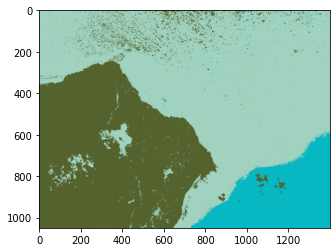

In [32]:
center = np.uint8(center)
#print(center)
res = center[lable.flatten()]
#print(res.shape)
res_image = res.reshape((o_img.shape))
plt.imshow(res_image)
clustered_img = Image.fromarray(res_image)
clustered_img.save('/content/drive/My Drive/Colab Notebooks/clustered_img.png')

In [33]:
image_one_array = []
image_two_array = []
image_three_array = []
for i in range(0, len(lable)):
    if lable[i][0] == 0:
        image_one_array.append(vector_img[i])
    elif lable[i][0] == 1:
        image_two_array.append(vector_img[i])
    else:
        image_three_array.append(vector_img[i])

len1 = len(image_one_array)
len2 = len(image_two_array)
len3 = len(image_three_array)

pad1 = math.ceil(math.sqrt(len1))**2 - len1
pad2 = math.ceil(math.sqrt(len2))**2 - len2
pad3 = math.ceil(math.sqrt(len3))**2 - len3

white = np.array([255.0, 255.0, 255.0], dtype=np.float32)

In [34]:
for i in range(0, pad1):
    image_one_array.append(white)
    
for i in range(0, pad2):
    image_two_array.append(white)

for i in range(0, pad3):
    image_three_array.append(white)
    
d1 = int(math.sqrt(len(image_one_array)))
#print(len(image_one_array), d1)
d2 = int(math.sqrt(len(image_two_array)))
#print(len(image_two_array), d2)
d3 = int(math.sqrt(len(image_three_array)))
#print(len(image_three_array), d3)

cluster1 = np.uint8(np.array(image_one_array)).reshape((d1, d1, 3))
cluster2 = np.uint8(np.array(image_two_array)).reshape((d2, d2, 3))
cluster3 = np.uint8(np.array(image_three_array)).reshape(d3, d3, 3)

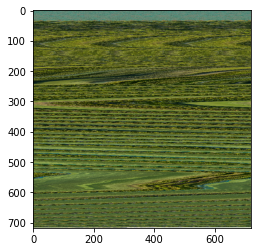

In [35]:
plt.imshow(cluster1)
cluster1_img = Image.fromarray(cluster1)
cluster1_img.save('/content/drive/My Drive/Colab Notebooks/cluster1_img.png')

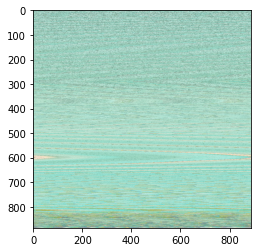

In [36]:
plt.imshow(cluster2)
cluster2_img = Image.fromarray(cluster2)
cluster2_img.save('/content/drive/My Drive/Colab Notebooks/cluster2_img.png')

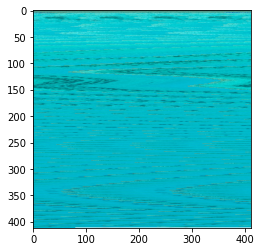

In [37]:
plt.imshow(cluster3)
cluster3_img = Image.fromarray(cluster3)
cluster3_img.save('/content/drive/My Drive/Colab Notebooks/cluster3_img.png')

In [38]:
def messageToBinary(message):
    if type(message) == str:
        return ''.join([ format(ord(i), "08b") for i in message ])
    elif type(message) == bytes: #or type(message) == np.ndarray:
        return ''.join([ format(i, "08b") for i in message ])
    elif type(message) == np.ndarray:
        return [format(i, "08b") for i in message]
    elif type(message) == int or type(message) == np.uint8:
        return format(message, "08b")
    else:
        raise TypeError("Input type not supported")

In [39]:
# Function to hide the secret message into the image

def hideData(image, secret_message):

      # calculate the maximum bytes to encode
    # print("Inside the hidedata function")
    n_bytes = image.shape[0] * image.shape[1] * 3 // 8
    # print("Maximum bytes to encode:", n_bytes)
    #Check if the number of bytes to encode is less than the maximum bytes in the image
    if len(secret_message) > n_bytes:
        raise ValueError("Error encountered insufficient bytes, need bigger image or less data !!")
  
    secret_message += b'#####' # you can use any string as the delimeter

    data_index = 0
    # convert input data to binary format using messageToBinary() fucntion
    binary_secret_msg = messageToBinary(secret_message)
    # print("bin sec msg:", binary_secret_msg)

    data_len = len(binary_secret_msg) #Find the length of data that needs to be hidden
    for values in image:
        for pixel in values:
            # convert RGB values to binary format
            # print("pixel:",pixel)
            # print(type(pixel))
            r, g, b = messageToBinary(pixel)
            # print("rgb:",r,g,b)
            # modify the least significant bit only if there is still data to store
            if data_index < data_len:
                # hide the data into least significant bit of red pixel
                pixel[0] = int(r[:-1] + binary_secret_msg[data_index], 2)
                data_index += 1
            if data_index < data_len:
                # hide the data into least significant bit of green pixel
                pixel[1] = int(g[:-1] + binary_secret_msg[data_index], 2)
                data_index += 1
            if data_index < data_len:
                # hide the data into least significant bit of  blue pixel
                pixel[2] = int(b[:-1] + binary_secret_msg[data_index], 2)
                data_index += 1
            
            # print("new Pixel:",pixel)
            # if data is encoded, just break out of the loop
            if data_index >= data_len:
                break
    
    # print("outside the nested loop")
    return image

In [40]:
def showData(image):
    # print('inside showdata')
    binary_data = ""
    for values in image:
        for pixel in values:
            r, g, b = messageToBinary(pixel) #convert the red,green and blue values into binary format
            binary_data += r[-1] #extracting data from the least significant bit of red pixel
            binary_data += g[-1] #extracting data from the least significant bit of red pixel
            binary_data += b[-1] #extracting data from the least significant bit of red pixel
    # split by 8-bits
    all_bytes = [ binary_data[i: i+8] for i in range(0, len(binary_data), 8) ]
    # convert from bits to characters
    decoded_data = b''
    for byte in all_bytes:
      try:
        decoded_data += int(byte, 2).to_bytes(len(byte) // 8, byteorder='big')#chr(int(byte, 2))
        if decoded_data[-5:] == b'#####': #check if we have reached the delimeter which is "#####"
            break
      except Exception as e:
        print(byte)
        break
    
    # print(decoded_data)
    return decoded_data[:-5] #remove the delimeter to show the original hidden message

In [41]:
def psnr(o_img,stg_img):
  mse=np.mean((o_img-stg_img)**2,dtype=np.float128)
  if(mse==0):
    return 100
  max_pixel=255.0
  psnr_val=20*log10(max_pixel/sqrt(mse))
  return psnr_val

In [42]:
def ssim(o_img,stg_img):
  grayA = cv2.cvtColor(o_img, cv2.COLOR_BGR2GRAY)
  grayB = cv2.cvtColor(stg_img, cv2.COLOR_BGR2GRAY)
  (score, diff) = compare_ssim(grayA, grayB, full=True)
  diff = (diff * 255).astype("uint8")

  # 6. You can print only the score if you want
  print("SSIM: {}".format(score))

In [43]:
def xor(s1, s2):
    return tuple(a^b for a,b in zip(s1, s2))

class AES1(object):
    class __metaclass__(type):
        def __init__(cls, name, bases, classdict):
            cls.Gmul = {}
            for f in (0x02, 0x03, 0x0e, 0x0b, 0x0d, 0x09):
                cls.Gmul[f] = tuple(cls.gmul(f, x) for x in range(0,0x100))

    Rcon = ( 0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a )
    Sbox = (
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            )
    Sbox_inv = (
            0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
            0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
            0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
            0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
            0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
            0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
            0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
            0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
            0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
            0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
            0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
            0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
            0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
            0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
            0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
            0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
            )

    @staticmethod
    def rot_word(word):
        return word[1:] + word[:1]
    key = 0
    

    def key_schedule(self):
        expanded = []
        expanded.extend(map(ord, self.key))
        for i in range(self.nk, self.nb * (self.nr + 1)):
            t = expanded[(i-1)*4:i*4]
            if i % self.nk == 0:
                t = xor( AES.sub_word( AES.rot_word(t) ), (AES.Rcon[i // self.nk],0,0,0) )
            elif self.nk > 6 and i % self.nk == 4:
                t = AES.sub_word(t)
            expanded.extend( xor(t, expanded[(i-self.nk)*4:(i-self.nk+1)*4]))
        return expanded

    def add_round_key(self, rkey):
        for i, b in enumerate(rkey):
            self.state[i] ^= b

    def sub_bytes(self):
        for i, b in enumerate(self.state):
            self.state[i] = AES.Sbox[b]

    def inv_sub_bytes(self):
        for i, b in enumerate(self.state):
            self.state[i] = AES.Sbox_inv[b]

    def shift_rows(self):
        rows = []
        for r in range(4):
            rows.append( self.state[r::4] )
            rows[r] = rows[r][r:] + rows[r][:r]


In [44]:
def sub_word(word):
        return (AES.Sbox[b] for b in word)

In [45]:
def text(msg):
  key = b'Sixteen byte key'
  if len(msg)%16 != 0:
    msg = msg + ' '*(16-len(msg)%16)

 # print("Message:", msg, len(msg))
  msg = msg.encode()
  cipher = AES.new(key, AES.MODE_ECB)
  enc_msg = cipher.encrypt(msg)
  print("\n\n\nSENDERS Side :  ")
  print("Encrypted message:  ", enc_msg)
  div_len = int(math.ceil(len(enc_msg)/3))
  chunk1 = enc_msg[0:div_len]
  chunk2 = enc_msg[div_len: 2*div_len]
  chunk3 = enc_msg[2*div_len:]


  image1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster1_img.png')
  image11 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster1_img.png')

  image_encoded1 = hideData(image1, chunk1)
  cv2.imwrite('/content/drive/My Drive/Colab Notebooks/cluster1_img_encoded.png', image_encoded1)

  image2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster2_img.png')
  image22 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster2_img.png')


  image_encoded2 = hideData(image2, chunk2)
  cv2.imwrite('/content/drive/My Drive/Colab Notebooks/cluster2_img_encoded.png', image_encoded2)

  image3 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster3_img.png')
  image33 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster3_img.png')
  image_encoded3 = hideData(image3, chunk3)
  cv2.imwrite('/content/drive/My Drive/Colab Notebooks/cluster3_img_encoded.png', image_encoded3)


  image_dec1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster1_img_encoded.png')
  decoded_chunk1 = showData(image_dec1)
  #print("decoded chunk1:",decoded_chunk1)

  image_dec2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster2_img_encoded.png')
  decoded_chunk2 = showData(image_dec2)
  #print("decoded chunk2:",decoded_chunk2)

  image_dec3 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster3_img_encoded.png')
  decoded_chunk3 = showData(image_dec3)
  #print("decoded chunk3:",decoded_chunk3)

  decoded_encrypted_msg = decoded_chunk1 + decoded_chunk2 + decoded_chunk3
  print("\n\n\nRECEIVERS SIDE:   ")
  print("decoded encrypted message:", decoded_encrypted_msg)

  dec_msg = cipher.decrypt(decoded_encrypted_msg)
  print("Decrypted Message:", dec_msg)

  '''print(" Psnr of Cluster 1",psnr(image11,image_dec1))
  print(" Psnr of Cluster 2",psnr(image22,image_dec2))
  print(" Psnr of Cluster 3",psnr(image33,image_dec3))

  print("SSIM of Cluster 1",ssim(image11,image_dec1))
  print("SSIM of Cluster 1",ssim(image22,image_dec2))
  print("SSIM of Cluster 1",ssim(image33,image_dec3))'''



  

In [46]:
def imge():
  secret_img= cv2.imread('/content/drive/My Drive/Colab Notebooks/s_img.png')
  secret_img = cv2.cvtColor(secret_img, cv2.COLOR_BGR2RGB)
  plt.imshow(secret_img)

  f_img=secret_img.flatten()
  print(f_img)
  str_text=f_img.tobytes()
  print(type(str_text))
  print(len(str_text))
  div_len = int(math.ceil(len(str_text)/3))
  print(div_len)
  chunk1 = str_text[0:div_len]
  chunk2 = str_text[div_len: 2*div_len]
  chunk3 = str_text[2*div_len:]


  image1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster1_img.png')
  image_encoded1 = hideData(image1, chunk1)
  cv2.imwrite('/content/drive/My Drive/Colab Notebooks/cluster1_img_encoded.png', image_encoded1)

  image2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster2_img.png')
  image_encoded2 = hideData(image2, chunk2)
  cv2.imwrite('/content/drive/My Drive/Colab Notebooks/cluster2_img_encoded.png', image_encoded2)

  image3 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster3_img.png')
  image_encoded3 = hideData(image3, chunk3)
  cv2.imwrite('/content/drive/My Drive/Colab Notebooks/cluster3_img_encoded.png', image_encoded3)

  image_dec1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster1_img_encoded.png')
  decoded_chunk1 = showData(image_dec1)

  image_dec2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster2_img_encoded.png')
  decoded_chunk2 = showData(image_dec2)

  image_dec3 = cv2.imread('/content/drive/My Drive/Colab Notebooks/cluster3_img_encoded.png')
  decoded_chunk3 = showData(image_dec3)

  decoded_encrypted_msg = decoded_chunk1 + decoded_chunk2 + decoded_chunk3


  np_img = np.frombuffer(decoded_encrypted_msg, dtype=np.uint8)
  print(type(np_img))
  o_img = np_img.reshape((secret_img.shape))

  filename="rec_img.png"
  r_img= Image.fromarray(secret_img)
  r_img.save('/content/drive/My Drive/Colab Notebooks/r_img.png')
  plt.imshow(o_img)

 Original Image:  


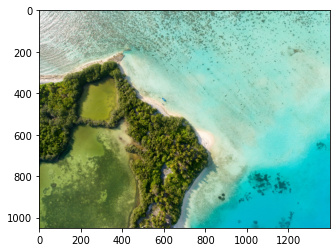

In [47]:
print(" Original Image:  ")
plt.imshow(o_img)

Enter 1 for text data, 2 for image data:1
Enter the message to be sent:   Steganography



SENDERS Side :  
Encrypted message:   b'\xb2o\xf5+`\xb9\xe2\xb4\x8b\xd8\xe8\xd6\xe4\xc9Qp'



RECEIVERS SIDE:   
decoded encrypted message: b'\xb2o\xf5+`\xb9\xe2\xb4\x8b\xd8\xe8\xd6\xe4\xc9Qp'
Decrypted Message: b'Steganography   '
Received Stego Image:  


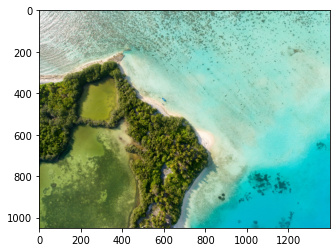

In [50]:
choice=int(input("Enter 1 for text data, 2 for image data:"))
if choice == 1:
  msg = input("Enter the message to be sent:   ")
  text(msg)
  print("Received Stego Image:  ")
  plt.imshow(steg_img)
else:
  imge()